# Notebook 1 — Básico (MLP simples) — 2025-08-16

Objetivo: pipeline mínimo de **pré-processamento → MLP → avaliação**, priorizando *recall*.

In [1]:
# Imports principais
import os, sys, json, math, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             precision_score, recall_score, f1_score, roc_auc_score)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print(f'Versões -> pandas {pd.__version__} | sklearn importado | tensorflow {tf.__version__}')

Versões -> pandas 2.2.2 | sklearn importado | tensorflow 2.17.0


In [2]:
# Caminho opcional para CSV do Kaggle. Se None, usa o dataset do sklearn.
CSV_PATH = None  # ex.: r"C:\\caminho\\breast_cancer.csv"
TARGET_COL = None  # se usar CSV, informe o nome exato da coluna alvo (ex.: 'diagnosis' ou 'target')

from sklearn.datasets import load_breast_cancer

if CSV_PATH and os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    if TARGET_COL is None:
        raise ValueError("Ao usar CSV, defina TARGET_COL com o nome da variável alvo.")
    y = df[TARGET_COL]
    X = df.drop(columns=[TARGET_COL])
    print(f'CSV carregado: {CSV_PATH} | X: {X.shape} | y: {y.shape}')
else:
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target, name='target')
    print(f'Dataset sklearn carregado | X: {X.shape} | y: {y.shape}')

# Identificar tipos
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f'Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}')

Dataset sklearn carregado | X: (569, 30) | y: (569,)
Numéricas: 30 | Categóricas: 0


In [3]:
# OneHotEncoder compatível com diferentes versões do sklearn
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        # fallback para versões antigas
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', make_ohe())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

In [4]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print('Split ->',
      'X_train:', X_train.shape, '| X_test:', X_test.shape,
      '| y_train:', y_train.shape, '| y_test:', y_test.shape)

Split -> X_train: (455, 30) | X_test: (114, 30) | y_train: (455,) | y_test: (114,)


In [5]:
# Ajustar o pré-processamento e transformar
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)
input_dim = X_train_proc.shape[1]
print('Dimensão após pré-processamento:', input_dim)

Dimensão após pré-processamento: 30


In [6]:
# Funções de plot (sem seaborn)
def plot_confusion_matrix(cm, class_names=('Benigno','Maligno')):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='Verdadeiro', xlabel='Previsto', title='Matriz de Confusão')
    # Anotações
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.show()

def plot_learning_curves(history, metric='recall'):
    train_metric = history.history.get(metric, [])
    val_metric = history.history.get(f'val_{metric}', [])
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs = range(1, len(train_loss)+1)

    # Métrica
    plt.figure(figsize=(7,5))
    plt.plot(epochs, train_metric, label=f'Treino {metric}')
    plt.plot(epochs, val_metric, label=f'Val {metric}')
    if val_metric:
        best_epoch = np.argmax(val_metric) + 1 if metric != 'loss' else np.argmin(val_metric) + 1
        plt.axvline(best_epoch, linestyle='--', label=f'Melhor época: {best_epoch}')
    plt.xlabel('Épocas'); plt.ylabel(metric.capitalize()); plt.title(f'Evolução de {metric}')
    plt.legend(); plt.tight_layout(); plt.show()

    # Loss
    plt.figure(figsize=(7,5))
    plt.plot(epochs, train_loss, label='Treino Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    if val_loss:
        best_epoch = np.argmin(val_loss) + 1
        plt.axvline(best_epoch, linestyle='--', label=f'Melhor época: {best_epoch}')
    plt.xlabel('Épocas'); plt.ylabel('Loss'); plt.title('Evolução da Loss')
    plt.legend(); plt.tight_layout(); plt.show()

In [7]:
# Avaliação utilitária
def evaluate_and_plot(model, X_test_proc, y_test, threshold=0.5):
    # Probabilidades e classe
    y_proba = model.predict(X_test_proc).ravel()
    y_pred = (y_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    print('Relatório de Classificação:\n', classification_report(y_test, y_pred, digits=4))
    print('Recall:', recall_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('F1:', f1_score(y_test, y_pred))
    try:
        print('ROC AUC:', roc_auc_score(y_test, y_proba))
    except Exception as e:
        print('ROC AUC n/d:', e)

    plot_confusion_matrix(cm, class_names=('Maligno','Benigno'))  # ajustar se necessário

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Curva ROC')
    plt.legend(); plt.tight_layout(); plt.show()

c:\Users\Fabio\anaconda3\envs\breast_cancer_env\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


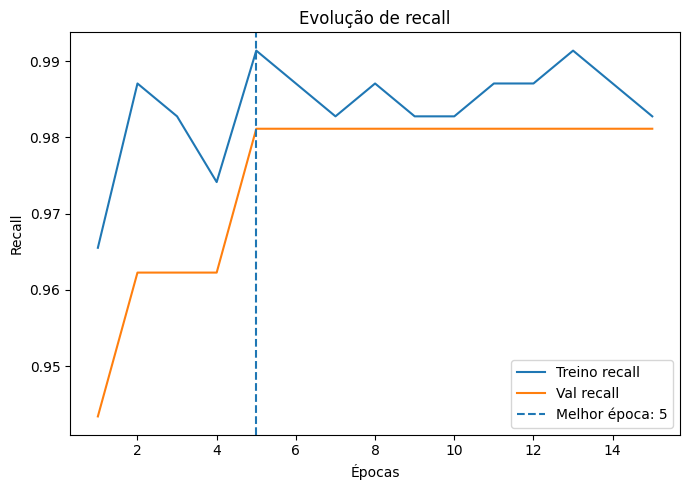

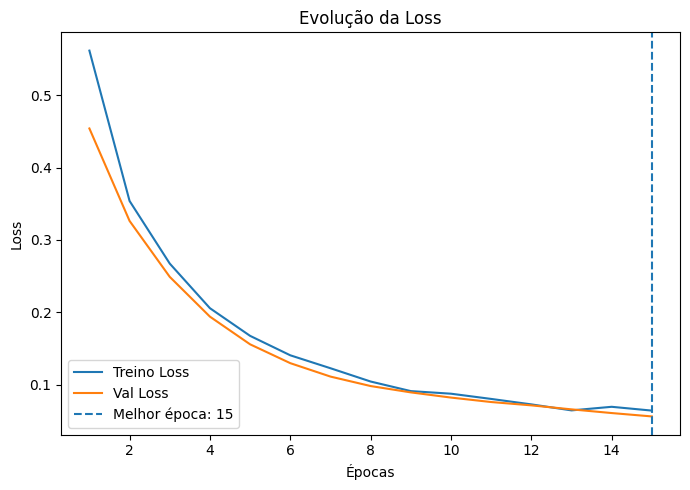

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9512    0.9286    0.9398        42
           1     0.9589    0.9722    0.9655        72

    accuracy                         0.9561       114
   macro avg     0.9551    0.9504    0.9526       114
weighted avg     0.9561    0.9561    0.9560       114

Recall: 0.9722222222222222
Precision: 0.958904109589041
F1: 0.9655172413793104
ROC AUC: 0.9930555555555556


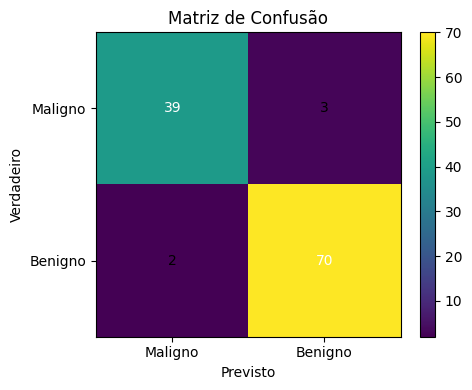

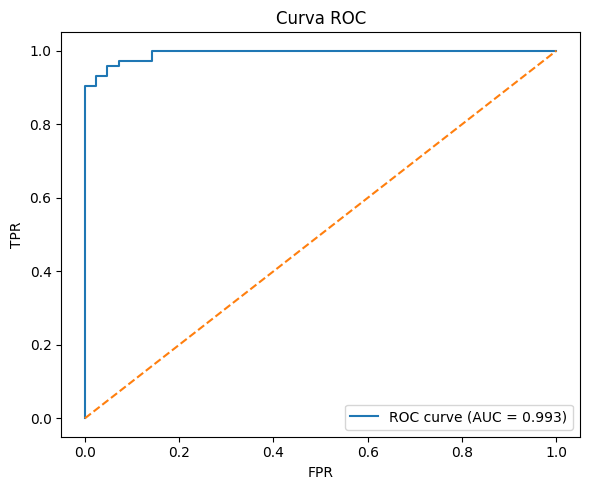

In [8]:
# Modelo MLP simples
model = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall(name='recall')])

early = EarlyStopping(monitor='val_recall', mode='max', patience=10, restore_best_weights=True)
history = model.fit(X_train_proc, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early], verbose=0)

plot_learning_curves(history, metric='recall')
evaluate_and_plot(model, X_test_proc, y_test, threshold=0.5)